In [33]:
# import the librarie
import numpy as np
import pandas as pd

# for plot
import matplotlib.pyplot as plt

### Import Dataset

In [20]:
# import our data frame
df = pd.read_csv("gold.csv")

In [21]:
df.head(5)

,date,open,max,min,close,x,y
0,2009.12.01,1179.40,1201.32,1175.23,1195.23,3636,0
1,2009.12.02,1195.65,1216.90,1195.30,1215.10,2376,0
2,2009.12.03,1215.15,1226.37,1204.28,1207.60,3664,0
3,2009.12.04,1207.80,1212.24,1147.32,1160.82,8287,0
4,2009.12.07,1159.43,1164.62,1135.53,1157.70,5646,0


In [50]:
# convert date object into datetime
df['date'] = pd.to_datetime(df['date'])

In [53]:
# set date as index
df.set_index('date', drop=True, inplace=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3442 entries, 2009-12-01 to 2023-03-14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3442 non-null   float64
 1   max     3442 non-null   float64
 2   min     3442 non-null   float64
 3   close   3442 non-null   float64
 4   x       3442 non-null   int64  
 5   y       3442 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 188.2 KB


### Preprocess Dataset

In [56]:
g_df = df[['open', 'max', 'min', 'close']]

In [57]:
g_df.head(5)

,open,max,min,close
date,,,,
2009-12-01,1179.40,1201.32,1175.23,1195.23
2009-12-02,1195.65,1216.90,1195.30,1215.10
2009-12-03,1215.15,1226.37,1204.28,1207.60
2009-12-04,1207.80,1212.24,1147.32,1160.82
2009-12-07,1159.43,1164.62,1135.53,1157.70


In [58]:
g_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3442 entries, 2009-12-01 to 2023-03-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3442 non-null   float64
 1   max     3442 non-null   float64
 2   min     3442 non-null   float64
 3   close   3442 non-null   float64
dtypes: float64(4)
memory usage: 134.5 KB


In [59]:
g_df.describe()

,open,max,min,close
count,3442.000000,3442.000000,3442.000000,3442.000000
mean,1453.530532,1463.665546,1443.072629,1453.646830
std,252.942917,255.027925,250.254596,252.918611
min,1050.740000,1063.430000,1044.460000,1050.870000
25%,1244.265000,1253.157500,1237.907500,1244.627500
50%,1343.840000,1352.635000,1333.070000,1344.605000
75%,1699.922500,1714.752500,1686.575000,1700.392500
max,2061.080000,2071.540000,2031.310000,2059.580000


### Visualize the dataset

In [ ]:
g_df.descrition()

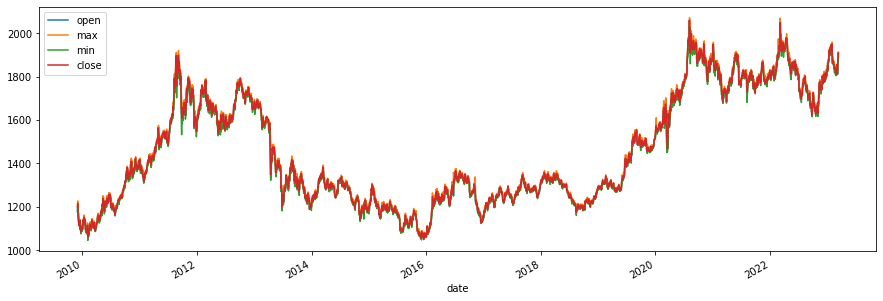

In [64]:
g_df.plot(figsize=(15, 5))
plt.show()

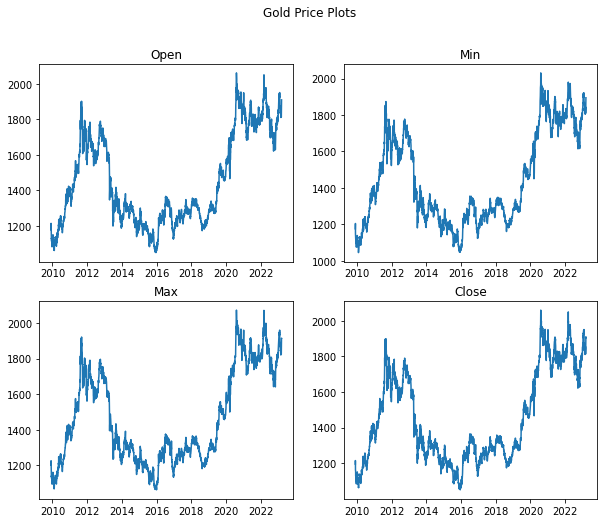

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
index = g_df.index
open_data = g_df['open']
min_data = g_df['min']
max_data = g_df['max']
close_data = g_df['close']

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the data on each subplot
axs[0, 0].plot(index, open_data)
axs[0, 0].set_title('Open')

axs[0, 1].plot(index, min_data)
axs[0, 1].set_title('Min')

axs[1, 0].plot(index, max_data)
axs[1, 0].set_title('Max')

axs[1, 1].plot(index, close_data)
axs[1, 1].set_title('Close')

# Add a main title to the figure
fig.suptitle('Gold Price Plots')

# Display the figure
plt.show()
